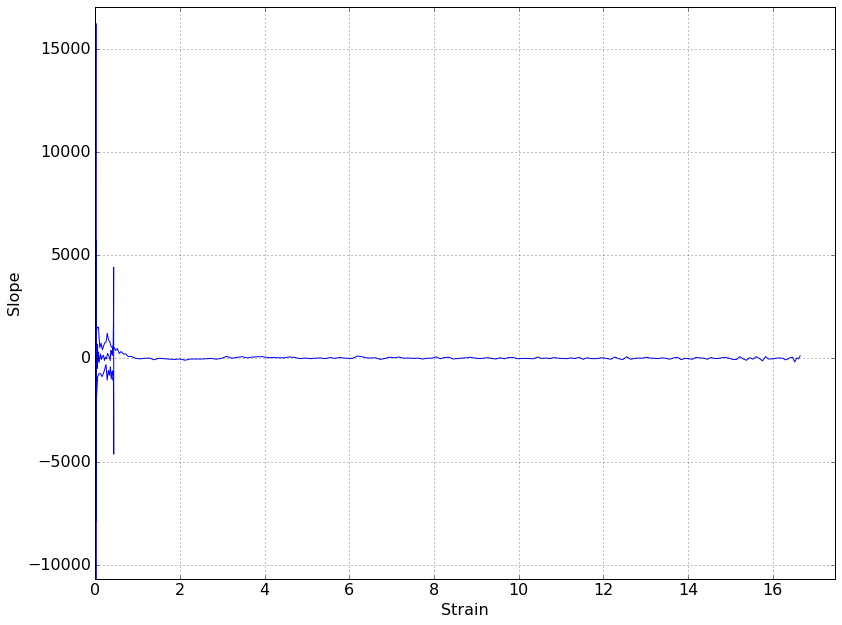

In [11]:
%load_ext autoreload
%autoreload 2  """Reloads all functions automatically"""
%matplotlib inline

from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np

model = strainmodel('ref/HSRS/22').get_experimental_data()

strain = model[:,0]
stress = model[:,1]

slopes = []

"""Approximating the partial derivatives of stress/strain"""
for index in xrange(len(stress)-1):
    slopes.append((stress[index+1]-stress[index])/(strain[index+1]-strain[index]))
    
"""Now what if we have strain vs slope"""
strainvslope = suite.combine_data(strain,slopes)
plot.plot2D(strainvslope,'Strain','Slope')

## It seems that based on these results it should be easy to cluster the data points

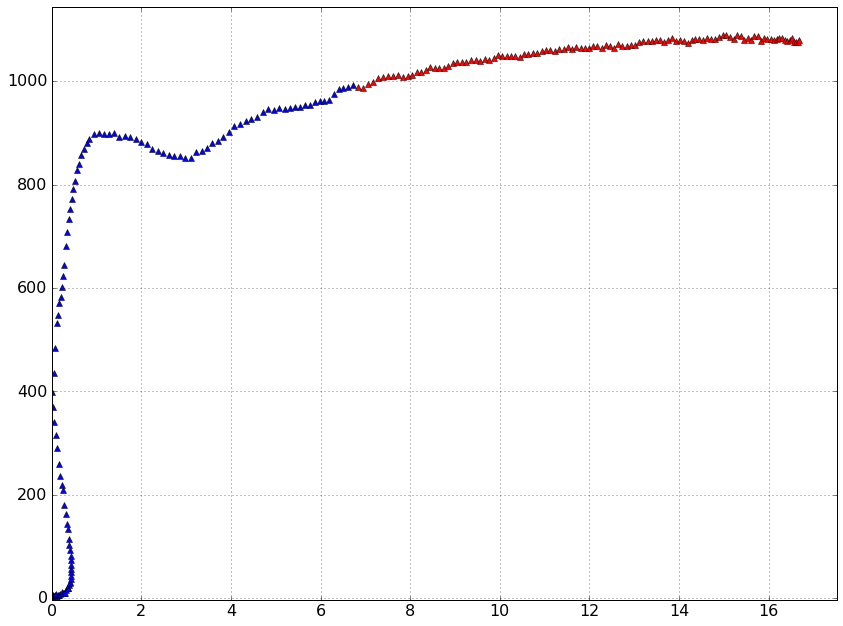

In [12]:
predictions = suite.kcluster(strainvslope, numclusters=2, init='random').predict(strain[:,None][:])
elastic, plastic = suite.splitdata(model,predictions)

plot.plotmult2D(elastic,plastic)

## This seems erroneous so let's look at the slopes that it believes are part of the same group

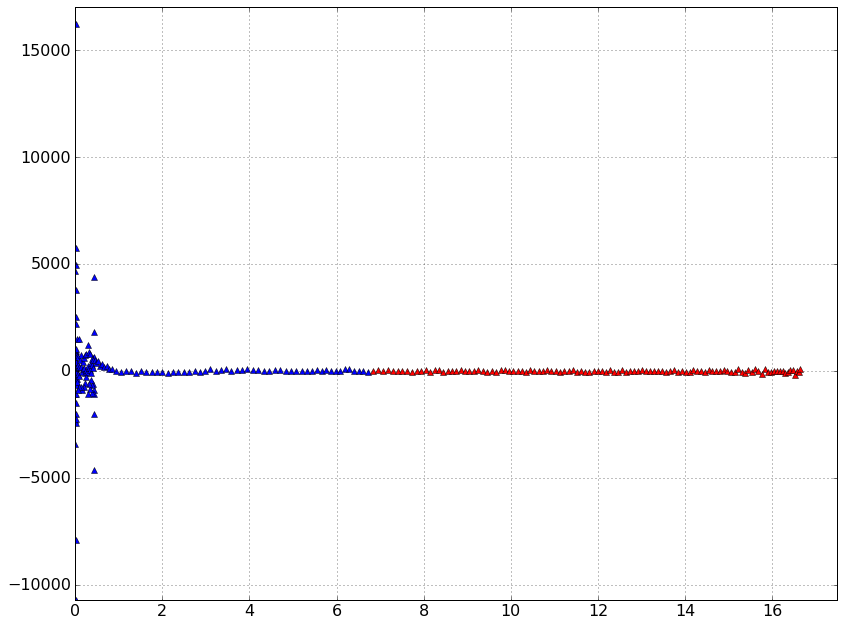

In [13]:
elastic_slope, plastic_slope = suite.splitdata(strainvslope, predictions)
plot.plotmult2D(elastic_slope,plastic_slope)

## Once the data slope begins decreasing, if we are far enough along we can say with confidence that yield is beginning

In [14]:
standard_deviation = np.std(slopes[:len(slopes)/4])
print standard_deviation

3122.09226699


In [15]:
yield_spot = 0

for index, slope in enumerate(slopes):
    
    if slope<-20 and index>(len(slopes)/4.):
        if slopes[index+1]<-20:
            yield_spot=index
            break
        
#print strain[yield_spot],stress[yield_spot]
#print slopes      

In [16]:
# -- this value needs to be high enough to get a good value, but low enough to avoid noisy data
num_intervals = 10

# -- divide into ten intervals and print stddev of each
divs = [np.std(vals) for vals in np.array_split(slopes,num_intervals)]

# -- stdev of the whole thing
stdev = np.std(slopes)

interval = 0
while divs[interval] > stdev:
    interval = interval + 1
    
# -- selects a point halfway in the interval
interval_length = len(model)/num_intervals
yield_index = ((int)(interval_length*interval*3./2.))

    
# -- found yield strain (ONLY TENTATIVELY WORKS -- REFINE THIS)
yield_strain = strain[yield_index]
yield_stress = stress[yield_index]

print divs

[4612.0882992710231, 426.06206684630507, 1515.1298640895604, 421.87182234860603, 48.777293699237568, 33.870484894562971, 28.784670818335488, 33.270855805159862, 31.012422403782136, 64.63547777934707]


[ 0.08134057  6.82299987]


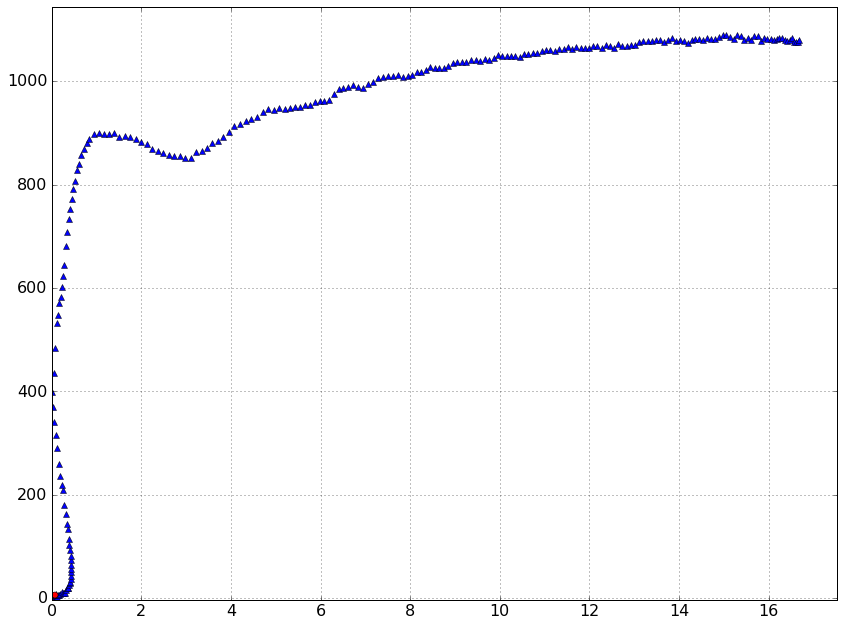

In [17]:
yielding = np.array([yield_strain,yield_stress])
print yielding

plot.plotmult2D(model,yielding[None,:],marker2='ro')

## The model is still highly subject to fluctuations from the number of intervals, and we need to select a place where the slope is negative mostly throughout the interval, and the standard deviation begins to decrease

In [48]:
# -- we think that yield occurs where the standard deviation is decreasing AND the slopes are mostly negative
def findYieldInterval(slopes, numberofsections):
    
    def numneg(val):
        return sum((val<0).astype(int))
    
    # -- divide into ten intervals and save stddev of each
    splitslopes = np.array_split(slopes,numberofsections)
      
    # -- displays the number of negative values in a range (USEFUL!!!)
    for section in splitslopes:
        print numneg(section), len(section)

    divs = [np.std(vals) for vals in splitslopes]
    
    # -- stddev of the whole thing
    stdev = np.std(slopes)
    
    interval = 0
    sect = splitslopes[interval]
    
    while divs[interval] > stdev or numneg(sect)<5*len(sect)/8:
        
        interval = interval + 1
        
        """Guard against going out of bounds"""
        if interval==len(splitslopes): break
            
        sect = splitslopes[interval]                                         
    
    print interval
    return interval

numberofsections = 15
interval_length = len(model)/numberofsections

"""
Middle of selected interval

Guard against going out of bounds
"""
yield_interval = findYieldInterval(slopes,numberofsections)
yield_index = min(yield_interval*interval_length + interval_length/2,len(strain)-1) 
yield_value = np.array([strain[yield_index],stress[yield_index]])[None,:]

print yield_value

9 18
9 18
6 18
13 18
6 18
3 18
10 17
3 17
2 17
6 17
8 17
10 17
5 17
8 17
9 17
6
[[   1.99905135  881.72090114]]


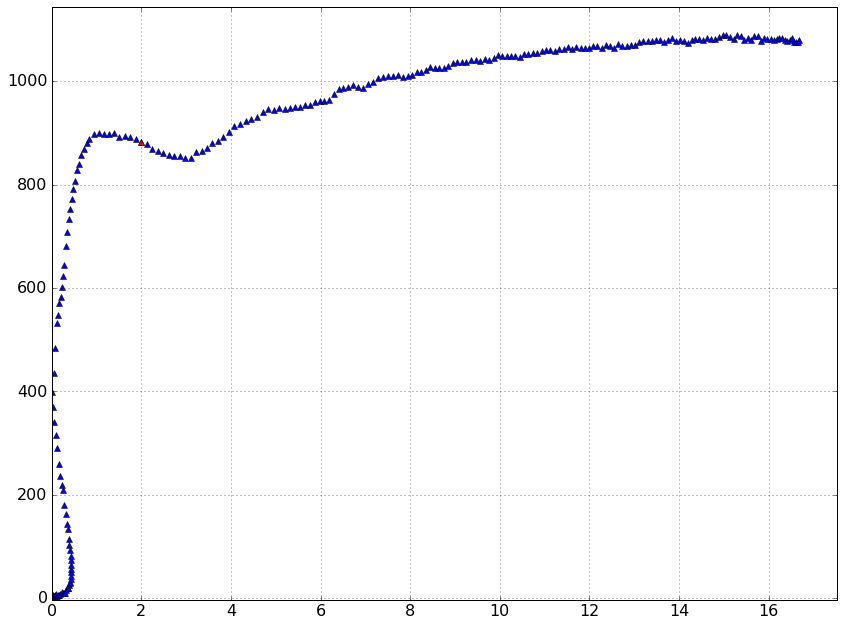

In [44]:
plot.plotmult2D(model,yield_value)

## Now we need to create a function that automatically determines the slopes from the data, calls the other function, and returns the appropriate values

[inf, -inf, inf, inf, -inf, nan, -inf, inf, -inf, inf, -inf, -inf, inf, -inf, inf, -inf, inf, inf, -inf, inf, -inf, inf, -inf, -inf, inf, -inf, inf, inf, -inf, inf, -inf, -inf, inf, inf, -inf, nan, inf, -inf, inf, -inf, -inf, inf, -inf, inf, -inf, inf, -inf, inf, inf, inf, -inf, inf, -inf, inf, -inf, inf, -inf, inf, -inf, inf, inf, -inf, inf, -inf, -inf, -inf, inf, inf, -inf, inf, -inf, inf, inf, -28.699912864328219, -79.392346245671504, -52.709914673414829, -114.57732916889127, -88.282900866978196, -86.320052208296289, -4928.440755382383, -39.723443389744929, -55.976693165434739, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, 314.13098855493672, -21.618471601818847, 124.39910888092849, -43.505904207266589, 65.816804901101065, 19.262341082263891, -9.8120107969432979, 84.542401728355628, 88.635783376324554, 45.946180707138481, 49.993505411850464, 89.213297682557652, 103.45143806165508

/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in double_scalars
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


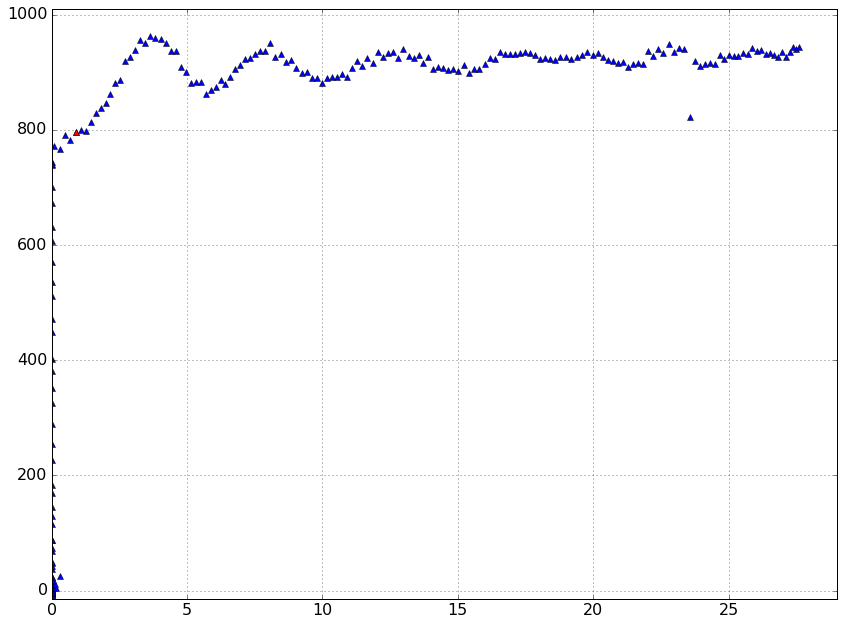

In [152]:
"""Yield occurs where the standard deviation is decreasing AND the slopes are mostly negative"""
def findYieldInterval(slopes, numberofsections):
    
    def numneg(val):
        return sum((val>0).astype(int))
    
    """Divide into ten intervals and save stddev of each"""
    splitslopes = np.array_split(slopes,numberofsections)
    divs = [np.std(vals) for vals in splitslopes]
    
    """Computes the reference standard deviation"""
    stdev = np.std(slopes)
    
    interval = 0
    sect = splitslopes[interval]
    
    while divs[interval] > stdev or numneg(sect)<3*len(sect)/4:
        
        interval = interval + 1
        
        """Guard against going out of bounds"""
        if interval==len(splitslopes): break
            
        sect = splitslopes[interval]                                         
    
    return interval

"""Returns yield value from a set of experimental data"""
def findYieldValue(model):
    
    """Separate appropriate values"""
    strain = model[:,0]
    stress = model[:,1]
    slopes = []

    """Approximating the partial derivatives of stress/strain"""
    for index in xrange(len(stress)-1):
        slopes.append((stress[index+1]-stress[index])/(strain[index+1]-strain[index]))
        
    print slopes
    """How many sections to create, depends on noisiness and courseness of data"""
    numberofsections = 10
    interval_length = len(model)/numberofsections
        
    """Middle of selected interval"""
    yield_index = findYieldInterval(slopes,numberofsections)*interval_length*3/2 
    yield_value = np.array([strain[yield_index],stress[yield_index]])[None,:]
    
    return yield_value

"""Plots data with superimposed yield value"""
def plotYieldValue(model):
    
    import graph_suite
    graph_suite.plotmult2D(model,findYieldValue(model))

#model1 = strainmodel('ref/HSRS/22').get_experimental_data()
model2 = strainmodel('ref/HSRS/222').get_experimental_data()
model3 = strainmodel('ref/HSRS/326').get_experimental_data()

#plotYieldValue(model1)
plotYieldValue(model3)

## Working, but we need to clean up issues with special indices and with illegitimate data

[555.50353242616472, -1052.6026184028797, -2297.3848942825398, 4691.5387672458819, -3401.9768639915055, 4977.2452344043177, -506.37934248574243, -526.5482410566417, 151.27434089289167, 0.042987490128562886, -7876.1458615485762, 5740.9851212577869, -10683.964792260265, 16239.143081132101, 2225.335752947286, 3797.0397615604656, -384.13788967865077, -1039.9036107769214, -2419.868132251007, 939.97549181577313, -2012.9378702992724, 2525.3515925629658, -536.59213189056868, -624.99730468081634, 262.79827821435168, 579.82460600633488, 970.73894920172552, -101.64804588287438, 48.433579792949487, 429.86489881516724, -1479.0671376894788, 765.93941818323003, -40.285076702862881, -378.59233258598562, 697.46614470709358, -480.68361339745047, 645.1063767490474, -135.52393607530644, 309.73531177091991, 203.46506839484192, -200.62619401120457, 216.41804006909018, -39.710304437378866, 99.47690269798872, 153.99717241031917, -95.871659511364413, 58.063287988629995, -19.754100600340834, 240.29557493401185,

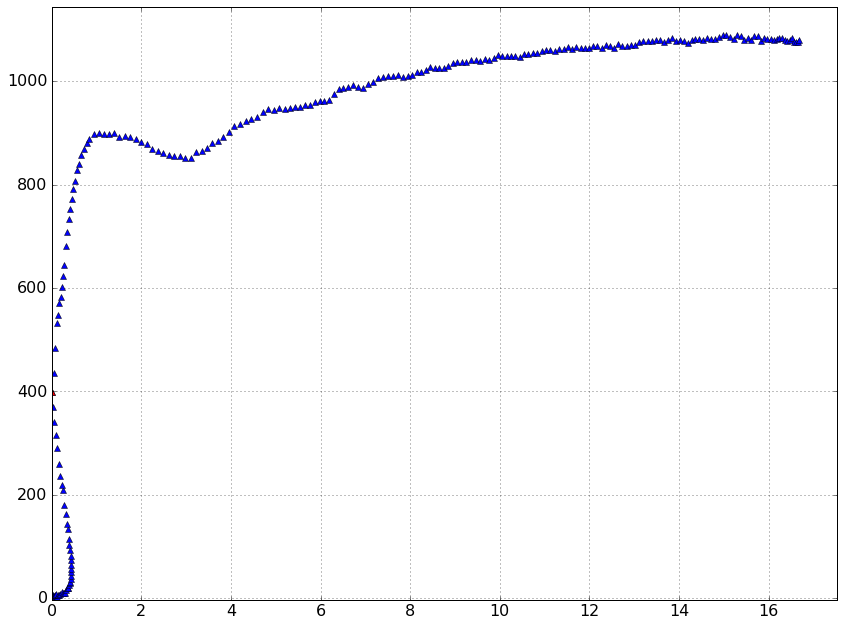

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 483.9074613791127, 55.042999302308317, 110.73772337860352, 81.55821186119735, 16.321886545443512, 155.26524796997816, -34.657395546455959, 52.377466712944305, -44.314592017158112, -25.304979173358394, -6.2223312337158383, -178.68391220094077, 122.66424938744959, -158.80885593350402, -5.8718500295551532, -13.368714319813277, -41.338583388880323, 46.377603721288978, -54.142953738878489, 53.384630071925812, 7.0662652222065674, 85.18925403548667, 96.432471525171891, -21.118424192751849, 102.28778900790611, -17.657800825343923, 88.873904977480336, 26.057424865319291, 3.1942738634831604, 62.59847877406331, -42.865208995862268, 50.7496524300022

/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in double_scalars


IndexError: index 375 is out of bounds for axis 0 with size 259

In [8]:
%matplotlib inline

from irreversible_stressstrain import StressStrain as strainmodel
import numpy as np

"""Yield occurs where the standard deviation is decreasing AND the slopes are mostly negative"""
def findYieldInterval(slopes, numberofsections):
    
    def numneg(val):
        return sum((val<0).astype(int))
    
    """Divide into ten intervals and save stddev of each"""
    splitslopes = np.array_split(slopes,numberofsections)
    divs = [np.std(vals) for vals in splitslopes]
    
    """Computes the reference standard deviation"""
    stdev = np.std(slopes)
    
    interval = 0
    sect = splitslopes[interval]
    
    while divs[interval] > stdev or numneg(sect)<3*len(sect)/4:
        
        interval = interval + 1
        
        """Guard against going out of bounds"""
        if interval==len(splitslopes): break
            
        sect = splitslopes[interval]                                         
    
    return interval

"""Returns yield value from a set of experimental data"""
def findYieldValue(model):
    
    """Separate appropriate values"""
    strain = model[:,0]
    stress = model[:,1]
    slopes = []

    """Approximating the partial derivatives of stress/strain"""
    for index in xrange(len(stress)-1):
        
        newslope = (stress[index+1]-stress[index])/(strain[index+1]-strain[index])
                    
        if np.isnan(newslope) or np.isinf(newslope):
            newslope = 0
                                                   
        slopes.append(newslope)
    
    print slopes
    
    """How many sections to create, depends on noisiness and courseness of data"""
    numberofsections = 10
    interval_length = len(model)/numberofsections
        
    """Middle of selected interval"""
    yield_index = findYieldInterval(slopes,numberofsections)*interval_length*3/2 
    yield_value = np.array([strain[yield_index],stress[yield_index]])[None,:]
    
    return yield_value

"""Plots data with superimposed yield value"""
def plotYieldValue(model):
    
    import graph_suite
    graph_suite.plotmult2D(model,findYieldValue(model))

model1 = strainmodel('ref/HSRS/22').get_experimental_data()
model2 = strainmodel('ref/HSRS/222').get_experimental_data()
model3 = strainmodel('ref/HSRS/326').get_experimental_data()

plotYieldValue(model1)
plotYieldValue(model2)
plotYieldValue(model3)